# Project 2

thoughts: using polar coordinates

In [75]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.special import rel_entr
from util import spike_gen

In [76]:
# Load the image
image_path = "assets/image.jpg"
image = Image.open(image_path)

image.size, image.mode

((7525, 5729), 'RGB')

resized image size: (752, 572)
gray image mode: L


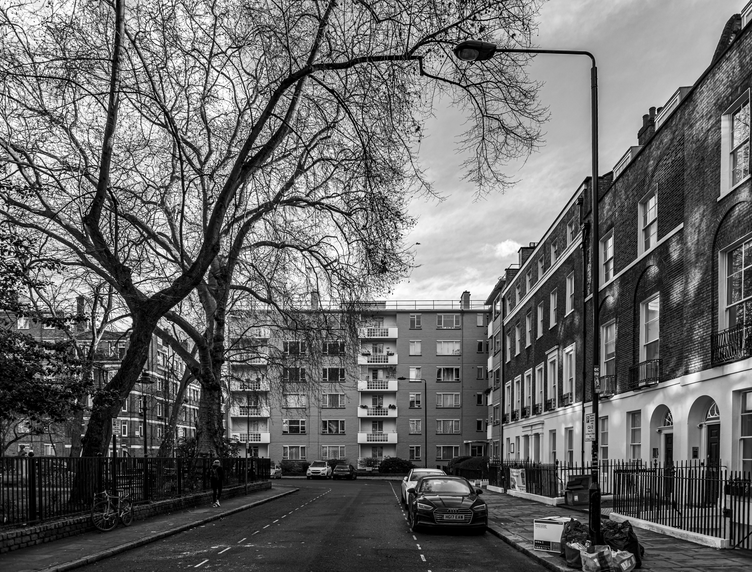

In [77]:
reduce_factor = 10

new_width = image.width // reduce_factor
new_height = image.height // reduce_factor

# Resize image using ANTIALIAS for better quality
resized_image = image.resize((new_width, new_height), Image.LANCZOS)
print("resized image size:", resized_image.size)
gray_image = resized_image.convert("L")
print("gray image mode:", gray_image.mode)
gray_image

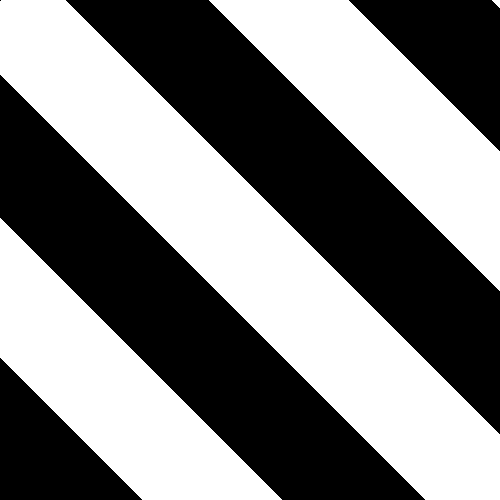

In [78]:
def create_grating(width=500, height=500, stripe_width=10, angle=0):
    """Create a black and white grating pattern image with a specified angle."""
    # Create a larger image to accommodate rotation
    diagonal = int(np.sqrt(width**2 + height**2))
    img = Image.new("L", (diagonal, diagonal), "white")
    draw = ImageDraw.Draw(img)

    # Draw parallel black stripes
    for x in range(0, diagonal, stripe_width * 2):
        draw.rectangle([(x, 0), (x + stripe_width, diagonal)], fill="black")

    # Rotate image
    img = img.rotate(angle, expand=True)

    # Crop to center with the original width and height
    left = (img.width - width) // 2
    top = (img.height - height) // 2
    img = img.crop((left, top, left + width, top + height))

    # Show and save the result
    return img

grating = create_grating(width=500, height=500, stripe_width=100, angle=45)
grating


## Gabor Function

$$
D_s(x, y) = \frac{1}{2\pi\sigma_x\sigma_y} \exp\left( -\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \right) \cos(kx - \phi).
$$

The parameters in this function determine the properties of the spatial receptive field: 
$\sigma_x$ and $\sigma_y$ determine its extent in the $x$ and $y$ directions, respectively;
$k$, the preferred spatial frequency, determines the spacing of light and dark bars that produce the maximum response 
(the preferred spatial wavelength is $2\pi/k$); and $\phi$ is the preferred spatial phase, which determines 
where the ON-OFF boundaries fall within the receptive field.


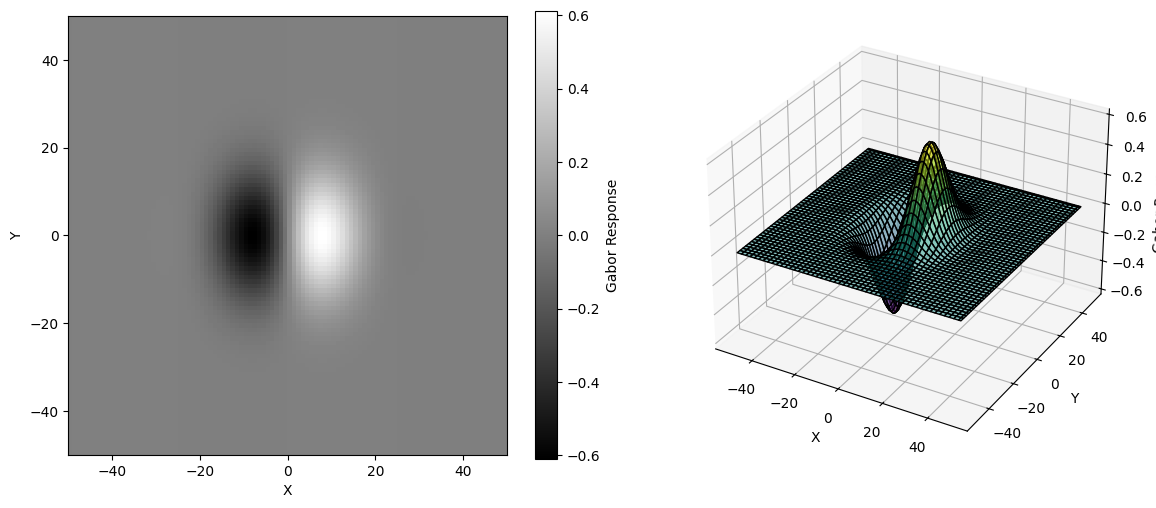

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gabor_function(x, y, wavelength, orientation, phase, sigma_x, sigma_y):
    """
    Computes the Gabor function.

    Parameters:
    x, y        : Grid coordinates
    wavelength  : Wavelength of the sinusoid
    orientation : Orientation of the Gabor filter in radians
    phase       : Phase offset of the sinusoid
    sigma_x     : Standard deviation of the Gaussian along x
    sigma_y     : Standard deviation of the Gaussian along y

    Returns:
    gabor       : The Gabor function evaluated at (x, y)
    """
    # Rotation of coordinates
    x_theta = x * np.cos(orientation) + y * np.sin(orientation)
    y_theta = -x * np.sin(orientation) + y * np.cos(orientation)

    # Gaussian Envelope
    gaussian_envelope = np.exp(-(x_theta**2 / (2 * sigma_x**2) + y_theta**2 / (2 * sigma_y**2)))

    # Sinusoidal Plane Wave
    sinusoid = np.cos(2 * np.pi * x_theta / wavelength + phase)

    # Gabor function
    gabor = gaussian_envelope * sinusoid

    return gabor

wavelength = 50 # Size of neuron
orientation = np.pi
phase = np.pi / 2
sigma_x = wavelength/5
sigma_y = wavelength/5

x = np.linspace(-wavelength, wavelength, wavelength * 2)
y = np.linspace(-wavelength, wavelength, wavelength * 2)
X, Y = np.meshgrid(x, y)

gabor = gabor_function(X, Y, wavelength, orientation, phase, sigma_x, sigma_y)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(gabor, cmap='gray', extent=[-wavelength, wavelength, -wavelength, wavelength])
fig.colorbar(im, ax=ax1, label="Gabor Response")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

# 3D Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d', elev=30, azim=-60)
ax2.plot_surface(X, Y, gabor, cmap='viridis', edgecolor='k', alpha=0.5)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Gabor Response")

# Show plots
plt.tight_layout()


## Estimating Firing Rate

$$
r_{est} = r_0 + F(L(t))
$$

assuming Linear Estimate and a separable temporal factor, we have

$$
F(L(t)) = L_s = \int dxdy \, D(x,y) s(x,y).
$$

where $L_s$ is the spatial linear estimate of the firing rate of a single neuron, $D(x,y)$ is the Gabor function, and $s(x,y)$ is the stimulus.

In [80]:
grating_array = np.array(grating, dtype=np.float32)
grating_array /= 255.0 # Normalize to [0, 1]

crop_size = wavelength * 2  # Size of the cropped area
neuron_center = (grating_array.shape[0] // 2 + wavelength, grating_array.shape[1] // 2) # (y, x)

grating_crop = grating.crop(
    (
        neuron_center[0] - crop_size // 2,
        neuron_center[1] - crop_size // 2,
        neuron_center[0] + crop_size // 2,
        neuron_center[1] + crop_size // 2,
    )
)
grating_crop_array = np.array(grating_crop, dtype=np.float32)
grating_crop_array /= 255.0 # Normalize to [0, 1]

r_est = np.sum(gabor * grating_crop_array)
r_est

np.float64(-51.19454854667841)

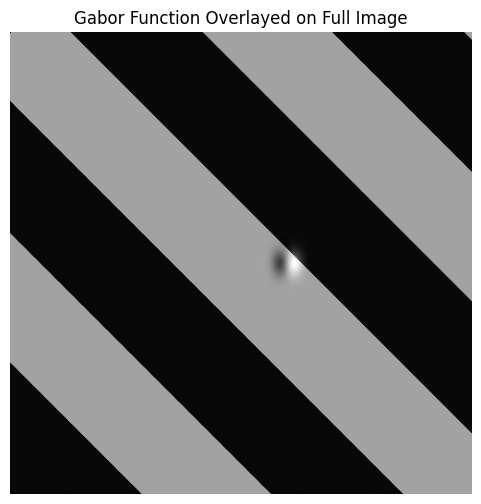

In [81]:
overlay = np.zeros_like(grating_array)
overlay[neuron_center[1] - crop_size // 2:neuron_center[1] + crop_size // 2, 
        neuron_center[0] - crop_size // 2:neuron_center[0] + crop_size // 2] = gabor

alpha = 0.5  # (0 = only image, 1 = only Gabor)
overlayed_image = (1 - alpha) * grating_array + alpha * overlay

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(overlayed_image, cmap="gray")
plt.title("Gabor Function Overlayed on Full Image")
plt.axis("off")
plt.show()

Decoded picture will be smaller to account for the size of the Gabor function.

## Encoding

array([[ 3.5563302e-01,  4.1046369e-01,  4.1860801e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.6904671e-03,  9.7973850e-03,  9.9381516e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.6977952e-03, -3.1360376e-03, -3.2051322e-03, ...,
        -5.9022795e-12,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.7251808e-02,  7.8020650e-03,  8.3786744e-04, ...,
        -9.7294534e-03, -8.3920257e-03, -4.9722879e-03],
       [ 8.3188206e-02,  2.5486421e-02,  2.9418839e-03, ...,
        -4.1001299e-01, -3.5365322e-01, -2.0954008e-01],
       [-4.3025389e-02, -1.2170233e-02, -1.2844700e-03, ...,
        -9.7828037e-01, -8.4380800e-01, -4.9995756e-01]],
      shape=(50, 50), dtype=float32)

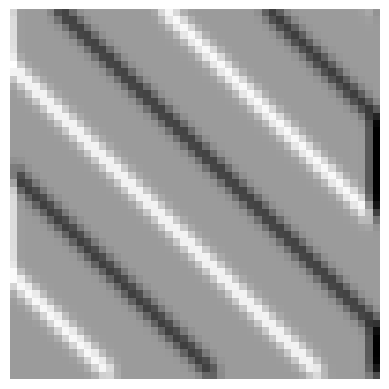

In [82]:
grating_array = np.array(grating, dtype=np.float32)
grating_array /= 255.0 # Normalize to [0, 1]

crop_size = wavelength * 2

n = 50
m = 50

r_est_array = np.zeros((n, m), dtype=np.float32)
for i in range(1,n+1):
    for j in range(1,m+1):
        neuron_center = (grating_array.shape[0] // n * i, grating_array.shape[1] // m * j)

        grating_crop = grating.crop(
            (
                neuron_center[0] - wavelength,
                neuron_center[1] - wavelength,
                neuron_center[0] + wavelength,
                neuron_center[1] + wavelength,
            )
        )
        grating_crop_array = np.array(grating_crop, dtype=np.float32)
        grating_crop_array /= 255.0 # Normalize to [0, 1]

        r_est_array[i-1, j-1] = np.sum(gabor * grating_crop_array)
r_est_array.max(), r_est_array.min()

r_est_array /= max(r_est_array.max(), abs(r_est_array.min()))
plt.imshow(r_est_array.transpose(), cmap="gray")
plt.axis("off")
r_est_array

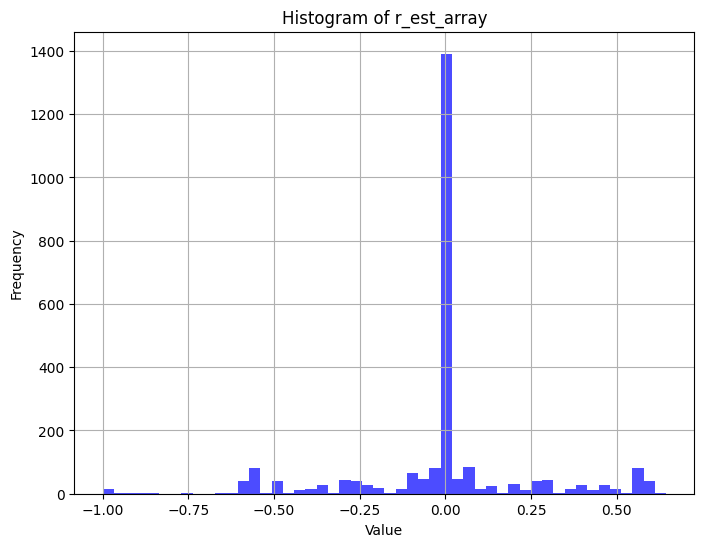

In [83]:
plt.figure(figsize=(8, 6))
plt.hist(r_est_array.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of r_est_array")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [90]:
r_est_array_scaled = ((r_est_array + 2) / 2) * 120
for r in r_est_array_scaled.flatten():
    if r <= 0:
        raise ValueError("r must be greater than 0")
    print(r)
    spike_dict = spike_gen.fast_spike_generator(r)
    print(spike_dict["Homogeneous w/ Refractory Effects"])

141.33798
[1.83327467e-04 2.94643767e-02 4.66066070e-02 5.91191372e-02
 6.38356292e-02 8.85002282e-02 1.11678654e-01 1.16385413e-01
 1.33466382e-01 1.67054416e-01 1.96167306e-01 2.16099896e-01
 2.26743103e-01 2.48803722e-01 2.81364135e-01 2.88737146e-01
 3.26232969e-01 3.46985322e-01 3.54390063e-01 3.61464688e-01
 3.67376712e-01 3.82545788e-01 3.87478050e-01 4.21816122e-01
 4.33827589e-01 4.38315667e-01 4.55080900e-01 4.57594133e-01
 4.84737869e-01 5.25582886e-01 5.39291536e-01 5.54840048e-01
 5.85389873e-01 5.92610906e-01 6.24631188e-01 6.46673529e-01
 6.52644386e-01 6.65313369e-01 6.88780483e-01 7.10933204e-01
 7.20665762e-01 7.36106534e-01 7.45802281e-01 7.61853662e-01
 7.95679213e-01 8.17396349e-01 8.36501393e-01 8.87458964e-01
 9.02232399e-01 9.22055359e-01 9.33234847e-01 9.40659657e-01
 9.63361551e-01 9.83262691e-01]
144.62782
[0.01986222 0.02234956 0.0555782  0.06655481 0.07824804 0.08960193
 0.11309562 0.12523368 0.14249166 0.14988402 0.17085979 0.20369393
 0.2376637  0.2488736

## Decoding

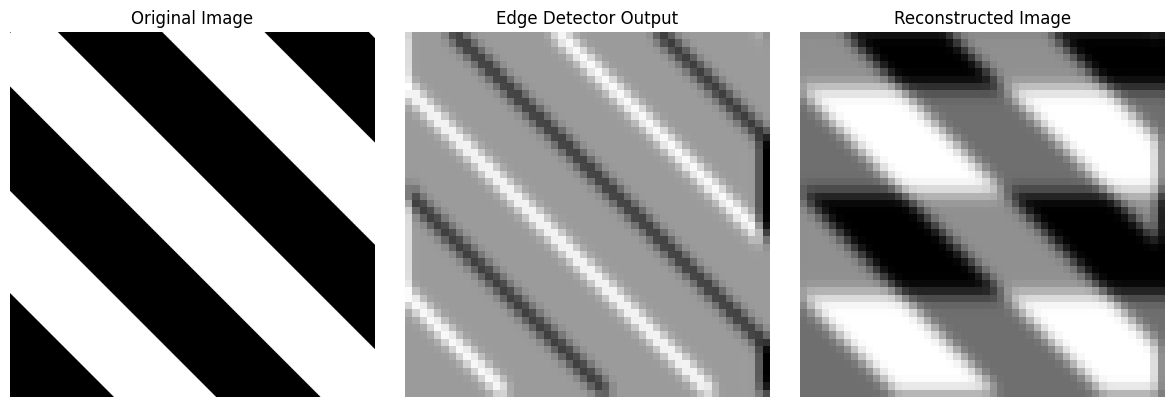

(np.float32(-1.0),
 np.float32(0.6444058),
 np.float32(-1.4258586),
 np.float32(1.85467))

In [85]:
decoded = np.cumsum(r_est_array, axis=0)

# Plot the images for comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(grating_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Edge Detector Output")
plt.imshow(r_est_array.transpose(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(decoded.transpose(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
r_est_array.min(), r_est_array.max(), decoded.min(), decoded.max()

## Analysis

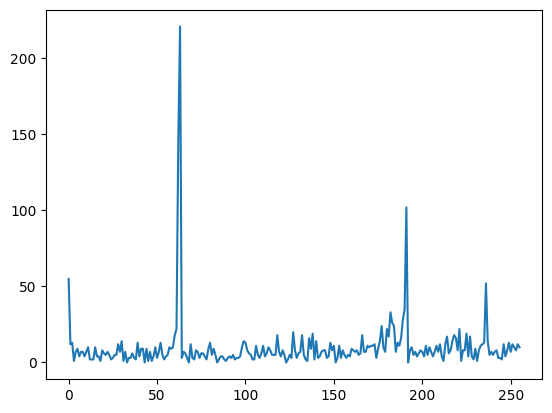

In [86]:
plt.plot(Image.fromarray(decoded, mode='L').histogram())

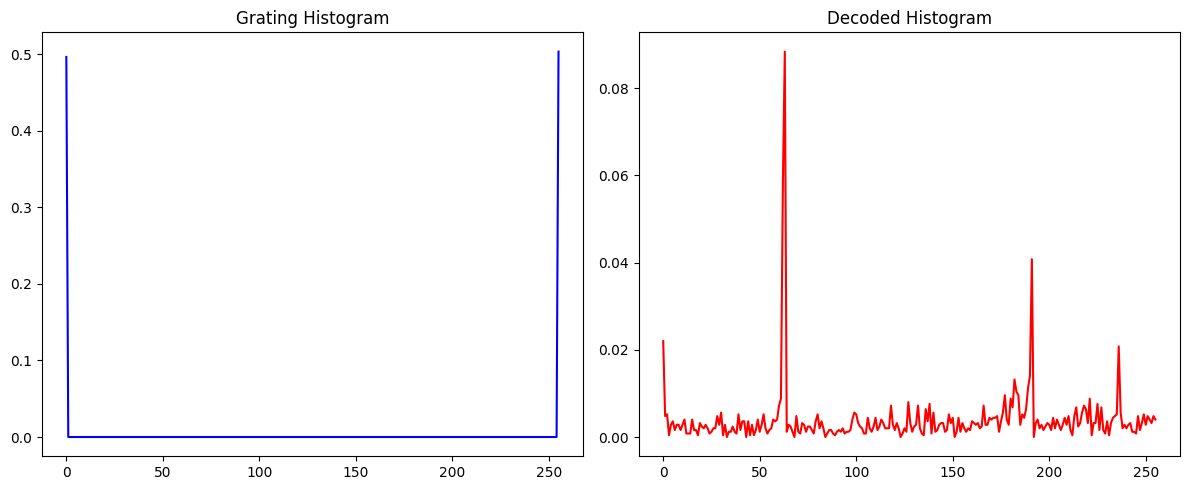

Relative Entropy: 3.98193080970601


In [87]:
# Example histograms
grating_histogram = np.array(grating.histogram())
decoded_histogram = np.array(Image.fromarray(decoded, mode='L').histogram())

# Normalize
grating_histogram = grating_histogram / grating_histogram.sum()
decoded_histogram = decoded_histogram / decoded_histogram.sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(grating_histogram, color='blue', label='Grating Histogram')
ax[0].set_title('Grating Histogram')
ax[1].plot(decoded_histogram, color='red', label='Decoded Histogram')
ax[1].set_title('Decoded Histogram')
plt.tight_layout()
plt.show()

# Compute KL divergence
rel_entr = np.sum(rel_entr(grating_histogram, decoded_histogram))  # rel_entr = P * log(P/Q)

print(f"Relative Entropy: {rel_entr}")
